In [1]:
%load_ext autoreload

%autoreload 2
    
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
DEST_DIR = Path('./output')

In [2]:
import numpy as np
import nibabel as nib
import torch
from torchvision import transforms
from torchir.utils import IRDataSet
from torch.utils.data import Dataset
from pathlib import Path

In [3]:
# Define a custom dataset for loading 3D CT images
class CTDataSet(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load NIFTI image
        image = nib.load(self.image_paths[idx]).get_fdata()
        
        # Convert the image data to float32 type, as PyTorch's default is float32
        image = np.asarray(image, dtype=np.float32)

        # Add channel dimension: [1, depth, height, width]
        image = np.expand_dims(image, axis=0)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

In [4]:
# Define the path to the directory containing NIFTI images
image_dir = Path("E:/s4692034/thorax_resampled")
image_paths = [str(p) for p in image_dir.glob("*.nii")]
# print(f"Found {len(image_paths)} images")

# TODO: how to make the network accept different matrix size
transform = None

# Create an instance of the CTDataSet
ct_dataset = CTDataSet(image_paths=image_paths, transform=transform)

# Use the IRDataSet wrapper to produce pairs for registration tasks
registration_dataset = IRDataSet(ct_dataset)

### Different input matrix size

In [12]:
# Define the path to the directory containing NIFTI images
image_dir = Path("/30days/s4692034/Diff_matrix")
image_paths = [str(p) for p in image_dir.glob("*.nii")]

# TODO: how to make the network accept different matrix size
transform = None

# Create an instance of the CTDataSet
ct_dataset = CTDataSet(image_paths=image_paths, transform=transform)

# Use the IRDataSet wrapper to produce pairs for registration tasks
registration_dataset = IRDataSet(ct_dataset)

### Visualize the dataset

In [7]:
def visualize_slices(volume, slice_direction="axial"):
    """
    Visualize 2D slices from a 3D volume.
    
    Parameters:
        - volume: 3D numpy array representing the CT volume.
        - slice_direction: Direction to slice the volume. Can be "axial", "coronal", or "sagittal".
    """
    if slice_direction == "axial":
        num_slices = volume.shape[2]
    elif slice_direction == "coronal":
        num_slices = volume.shape[1]
    elif slice_direction == "sagittal":
        num_slices = volume.shape[0]
    else:
        raise ValueError("Invalid slice_direction. Choose from 'axial', 'coronal', or 'sagittal'.")
    
    # Function to display a specific slice
    def display_slice(slice_idx):
        if slice_direction == "axial":
            plt.imshow(volume[:, :, slice_idx], cmap="gray")
        elif slice_direction == "coronal":
            plt.imshow(volume[:, slice_idx, :], cmap="gray")
        else:  # sagittal
            plt.imshow(volume[slice_idx, :, :], cmap="gray")
        plt.axis("off")
        plt.title(f"{slice_direction.capitalize()} Slice {slice_idx}")
    
    # Use interactive slider for slice selection
    from ipywidgets import interact
    interact(display_slice, slice_idx=(0, num_slices-1))

# Example usage:
# Assuming 'fixed_image' and 'moving_image' are 3D numpy arrays from your dataset
fixed_image = np.squeeze(registration_dataset[0]["fixed"])
moving_image = np.squeeze(registration_dataset[0]["moving"])


# Visualize slices of the fixed image
visualize_slices(fixed_image, slice_direction="axial")

# Visualize slices of the moving image
visualize_slices(moving_image, slice_direction="axial")

interactive(children=(IntSlider(value=174, description='slice_idx', max=349), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=174, description='slice_idx', max=349), Output()), _dom_classes=('widget…

In [5]:
from torch.utils.data import random_split

# Set up a random number generator
rng = np.random.default_rng(617)

# Split the dataset into training, validation, and test sets
val_set_size = 20
test_set_size = 100
train_set_size = len(ct_dataset) - val_set_size - test_set_size

ds_train_subset, ds_validation_subset, ds_test_subset = random_split(ct_dataset, [train_set_size, val_set_size, test_set_size], 
                                                        generator=torch.Generator().manual_seed(617))

print(f'Training subset size: {len(ds_train_subset)}')
print(f'Validation subset size: {len(ds_validation_subset)}')
print(f'Test subset size: {len(ds_test_subset)}')

Training subset size: 309
Validation subset size: 20
Test subset size: 100


In [6]:
# Create instances of the IRDataSet for training and validation sets to produce pairs for registration tasks
ds_train = IRDataSet(ds_train_subset)
ds_validation = IRDataSet(ds_validation_subset)

print(f'Training IR set size: {len(ds_train)}')
print(f'Validation IR set size: {len(ds_validation)}')

Training IR set size: 95481
Validation IR set size: 400


In [7]:
batch_size = 2
training_batches = 50
validation_batches = 10

# RandomSampler: Samples elements randomly from a given list of indices, with replacement.
# num_samples: ensures that we get the desired number of training samples for each epoch.
train_sampler = torch.utils.data.RandomSampler(ds_train, replacement=True, 
                                               num_samples=training_batches*batch_size, 
                                               generator=torch.Generator().manual_seed(617))

# DataLoader: Combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = torch.utils.data.DataLoader(ds_train, batch_size, sampler=train_sampler)

# Since no sampler is provided, it will simply iterate over the dataset in its original order.
val_loader = torch.utils.data.DataLoader(ds_validation, batch_size)

In [11]:
import pytorch_lightning as pl
from torchir.networks import AIRNet
from torchir.transformers import AffineTransformer
from torchir.metrics import NCC


class LitAIRNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.airnet = AIRNet(kernels=16, ndim=3)
        self.global_transformer = AffineTransformer(ndim=3)
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        optimizer = torch.optim.Adam(self.airnet.parameters(), lr=lr, amsgrad=True)
        return optimizer

    def forward(self, fixed, moving):
        # Get the transformation parameters between the fixed and moving images
        parameters = self.airnet(fixed, moving)

        # Apply this transformation to the moving image, producing the "warped" image.
        warped  = self.global_transformer(parameters, fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  

In [11]:
model = LitAIRNet()
trainer = pl.Trainer(default_root_dir=DEST_DIR, 
                     log_every_n_steps=50,
                     val_check_interval=50, 
                     max_epochs=100)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type              | Params
---------------------------------------------------------
0 | airnet             | AIRNet            | 35.4 K
1 | global_transformer | AffineTransformer | 0     
2 | metric             | NCC               | 0     
---------------------------------------------------------
35.4 K    Trainable params
0         Non-trainable params
35.4 K    Total params
0.142     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [12]:
trainer.save_checkpoint(DEST_DIR / 'mnist_ir_affine.ckpt')

model = LitAIRNet.load_from_checkpoint(checkpoint_path="/data/home/s4692034/PythonProject/TorchIR/output/lightning_logs/version_0/checkpoints/epoch=25-step=130.ckpt")

  0%|          | 0/5 [00:00<?, ?it/s]

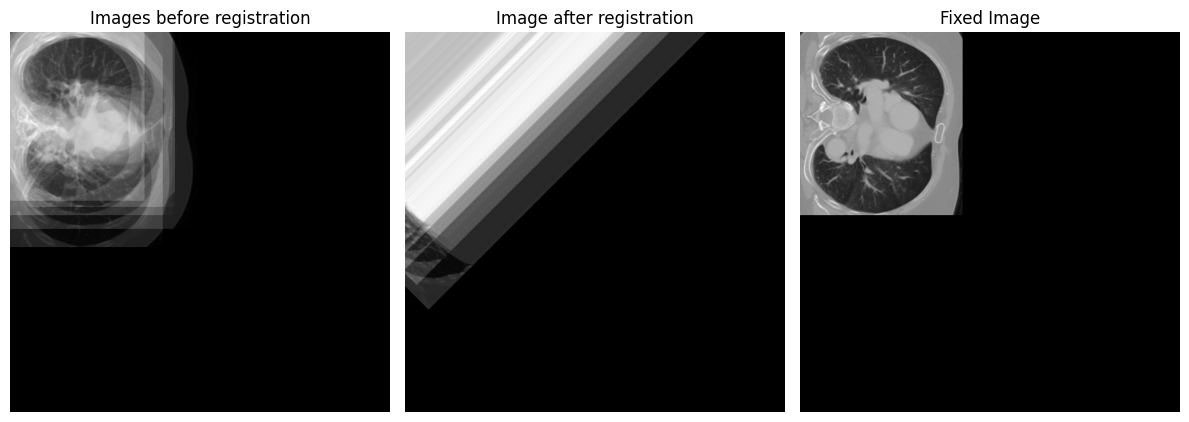

In [26]:
# Assuming your 3D CT images have shape (500, 500, 350)
avg_moving = np.zeros((500, 500, 350), dtype=float)
avg_warped = np.zeros((500, 500, 350), dtype=float)

model = model.cpu()
model.eval()
fixed = ds_test_subset[0]

with torch.no_grad():
    for moving in tqdm(ds_test_subset):
        # If they are numpy arrays, convert to PyTorch tensors
        if isinstance(fixed, np.ndarray):
            fixed = torch.tensor(fixed)
        if isinstance(moving, np.ndarray):
            moving = torch.tensor(moving)

        # moving = data['moving']
        warped = model(fixed[None].cpu(), moving[None].cpu()).detach().squeeze().cpu().numpy()
        
        avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
        avg_warped += warped / len(ds_test_subset)

# Now, for visualization, you might want to display a slice from the middle
slice_idx = 100

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(avg_moving[:, :, slice_idx], cmap='gray')
plt.title('Images before registration')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(avg_warped[:, :, slice_idx], cmap='gray')
plt.title('Image after registration')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fixed.squeeze().cpu().numpy()[:, :, slice_idx], cmap='gray')
plt.title('Fixed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
# Convert avg_warped to NIFTI image
warped_img_nifti = nib.Nifti1Image(avg_warped, np.eye(4))

# Save the image
nib.save(warped_img_nifti, './avg_warped.nii.gz')

In [2]:
import nibabel as nib

path = 'E:/s4692034/thorax_resampled/resampled_63464433c8_CT_cropped_normalized.nii'
image = nib.load(path).get_fdata()


FileNotFoundError: No such file or no access: 'E:/s4692034/thorax_resampled/resampled_63464433c8_CT_cropped_normalized.nii'

In [10]:
import pytorch_lightning as pl
from torchir.metrics import NCC
from torchir.dlir_framework import DLIRFramework
from torchir.networks import DIRNet
from torchir.transformers import BsplineTransformer

class LitDLIRFramework(pl.LightningModule):
    def __init__(self, only_last_trainable=True):
        super().__init__()
        self.dlir_framework = DLIRFramework(only_last_trainable=only_last_trainable)
        self.add_stage = self.dlir_framework.add_stage
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.002
        weight_decay = 0
        optimizer = torch.optim.Adam(self.dlir_framework.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=True)
        return {'optimizer': optimizer}

    def forward(self, fixed, moving):
        warped = self.dlir_framework(fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss

c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
model = LitDLIRFramework()
model.add_stage(network=DIRNet(grid_spacing=(8, 8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2, ndim=3),
                transformer=BsplineTransformer(ndim=3, upsampling_factors=(8, 8, 8)))
trainer = pl.Trainer(default_root_dir=DEST_DIR,
                     log_every_n_steps=50,
                     val_check_interval=50,
                     max_epochs=100,
                     strategy='ddp_spawn')
trainer.fit(model, train_loader, val_loader)

MisconfigurationException: `Trainer(strategy='ddp_spawn')` is not compatible with an interactive environment. Run your code as a script, or choose one of the compatible strategies: `Fabric(strategy='dp'|'ddp_notebook')`. In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

In [16]:
trainer.save_checkpoint(DEST_DIR / 'mnist_dlir_8.ckpt')

In [12]:
# Assuming your 3D CT images have shape (500, 500, 350)
avg_moving = np.zeros((500, 500, 350), dtype=float)
avg_warped = np.zeros((500, 500, 350), dtype=float)

model = model.cuda()
model.eval()
fixed = ds_test_subset[0]

with torch.no_grad():
    for moving in tqdm(ds_test_subset):
        # If they are numpy arrays, convert to PyTorch tensors
        if isinstance(fixed, np.ndarray):
            fixed = torch.tensor(fixed)
        if isinstance(moving, np.ndarray):
            moving = torch.tensor(moving)

        # moving = data['moving']
        warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()
        
        avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
        avg_warped += warped / len(ds_test_subset)

# Now, for visualization, you might want to display a slice from the middle
slice_idx = 50

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(avg_moving[:, :, slice_idx], cmap='gray')
plt.title('Images before registration')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(avg_warped[:, :, slice_idx], cmap='gray')
plt.title('Image after registration')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fixed.squeeze().cpu().numpy()[:, :, slice_idx], cmap='gray')
plt.title('Fixed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [13]:
def visualize(checkpoint_path):
    # Load the model from the checkpoint
    model = LitDLIRFramework.load_from_checkpoint(checkpoint_path=checkpoint_path)
    
    avg_moving = np.zeros((500, 500, 350), dtype=float)
    avg_warped = np.zeros((500, 500, 350), dtype=float)

    model = model.cuda()
    model.eval()
    fixed = ds_test_subset[0]

    with torch.no_grad():
        for moving in tqdm(ds_test_subset):
            if isinstance(fixed, np.ndarray):
                fixed = torch.tensor(fixed)
            if isinstance(moving, np.ndarray):
                moving = torch.tensor(moving)

            warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()
            avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
            avg_warped += warped / len(ds_test_subset)

    # Visualization
    slice_idx = 50
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(avg_moving[:, :, slice_idx], cmap='gray')
    plt.title('Images before registration')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(avg_warped[:, :, slice_idx], cmap='gray')
    plt.title('Image after registration')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(fixed.squeeze().cpu().numpy()[:, :, slice_idx], cmap='gray')
    plt.title('Fixed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # After training, load the model and visualize the results
    # checkpoint_path = DEST_DIR / 'mnist_dlir_8.ckpt'
    checkpoint_path = "D:\\Temp\\s4692034\\TorchIR\\output\\lightning_logs\\version_44\\checkpoints\\epoch=9-step=250.ckpt"
    visualize(checkpoint_path)